In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

In [2]:
f_test = h5py.File('test_catvnoncat.h5', 'r')
f_train = h5py.File('train_catvnoncat.h5', 'r')

In [3]:
X_train = np.array(f_train['train_set_x'])
y_train = np.array(f_train['train_set_y']).reshape(-1, 1)

In [4]:
X_test = np.array(f_test['test_set_x'])
y_test = np.array(f_test['test_set_y']).reshape(-1, 1)

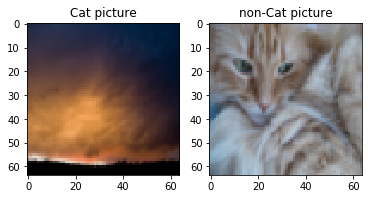

In [5]:
plt.subplot(1,2,1)
plt.imshow(X_train[0])
plt.title('Cat picture')
plt.subplot(1,2,2)
plt.imshow(X_train[2])
plt.title('non-Cat picture')
plt.show()

## Part One

در این روش قرار است برداری از وزن‌ها داشته باشیم که هر بار برای پیشبینی استفاده میشوند و پس از انجام پیشبینی مقدار کاست حساب شده  و با توجه به جواب‌های درست گرادیان ها محاسبه می‌شوند.

سپس گرادیان‌ها برای آپدیت بردار وزن‌ها استفاده میشوند.

برای سهولت بایاس نیز به عنوان یک وزن در نظر گرفته شده که به داده‌های ورودی عدد ثابت یک را متانظر با بایاس اضافه میکنیم.

In [6]:
def sigmoid(x, derivative=False):
    if derivative:
        return d_sigmoid(x)
    else:
        return 1/(1+np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def prob(theta, x):
    return sigmoid(np.dot(x, theta))

def cost_func(y_hat, y):
    m = y_hat.shape[0]
    total_cost = np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return total_cost / (-m)

def gradient(x, y_hat, y):
    m = x.shape[0]
    return (1 / m) * np.dot(x.T, y_hat - y)

def prepare_data(X):
    X = X.reshape((X.shape[0], -1))
    X = np.c_[np.ones((X.shape[0], 1)), X]
    return X / 255

class LogisticRegression:
    def __init__(self, alpha=0.001):
        self.alpha = alpha

    def fit(self, X_train, y_train, X_test=None, y_test=None, epochs=2000):
        X_train_flatten = prepare_data(X_train)
        if X_test is not None:
            X_test_flatten = prepare_data(X_test)
        self.theta = (np.random.rand(X_train_flatten.shape[1], 1) - 0.5)
        self.train_costs = []
        self.test_costs = []
        for e in range(epochs):
            
            if X_test is not None:
                y_hat_test = prob(self.theta, X_test_flatten)
                self.test_costs.append(cost_func(y_hat_test, y_test))
                
            y_hat_train = prob(self.theta, X_train_flatten)
            self.train_costs.append(cost_func(y_hat_train, y_train))
             
            g = gradient(X_train_flatten, y_hat_train, y_train)
            self.theta = self.theta - self.alpha * g    
            
    def predict(self, X_test):
        X_test_flatten = prepare_data(X_test)
        y_hat = prob(self.theta, X_test_flatten)
        return np.round(y_hat)
    

In [198]:
model = LogisticRegression(alpha=0.003)
model.fit(X_train, y_train, X_test, y_test, 2000)
y_pred = model.predict(X_test).astype(int)

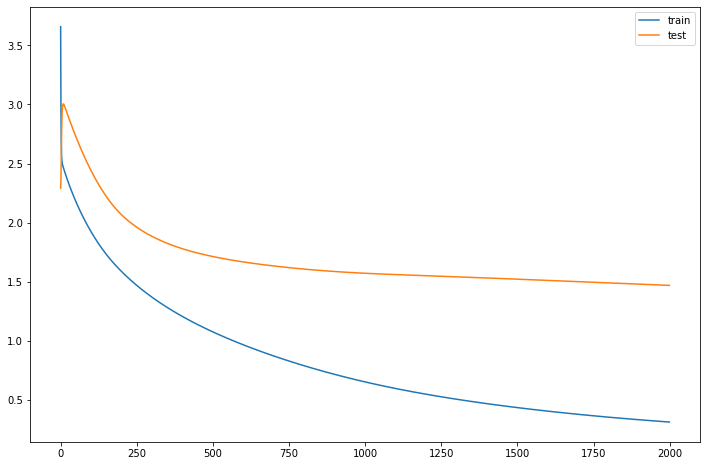

In [199]:
plt.figure(figsize=(12, 8))
plt.plot(model.train_costs, label='train')
plt.plot(model.test_costs, label='test')
plt.legend()

In [200]:
print("Final Loss on train data:", model.train_costs[-1])
print("Final Loss on test data:", model.test_costs[-1])

Final Loss on train data: 0.31202278923661586
Final Loss on test data: 1.4685752482996788


In [201]:
confusion_matrix = np.zeros((2, 2))
for i in range(len(y_pred)):
    confusion_matrix[y_test[i][0]][y_pred[i][0]] += 1

In [202]:
acc = np.diag(confusion_matrix).sum() / np.sum(confusion_matrix)
recall = confusion_matrix[1][1] / confusion_matrix.sum(axis=1)[1]
precision = confusion_matrix[1][1] / confusion_matrix.sum(axis=0)[1]

In [203]:
print('Accuracy:', acc)
print('Recall:', recall)
print('Precision:', precision)

Accuracy: 0.66
Recall: 0.6060606060606061
Precision: 0.8333333333333334


Accurcay shows how well has our model performed in predicting true classes.

Recall and Precision are calculated for each class separately.

Recall shows the portion of cats that have been classified as a cat.

Precision shows the portion of cats among all pictures classifed as cats.

## Part Two

در این روش بین هر دو لایه یک ماتریس وزن‌ها و برای هر لایه یک ماتریس بایاس در نظر میگیریم
سپس در مرحله‌ی فوروارد داده‌هارا لایه به لایه رد میکنیم و جواب نهایی را میسازیم.

پس از محاسبه‌ی کاست، در مرحله‌ی بک‌پراپ از آخرین لایه شروع کرده و گرادیان هر لایه را حساب میکنیم و سپس با استفاده از آنها وزن‌ها را آپدیت میکنیم.

برای اینکه یادگیری در ایپاک‌های کمتری صورت بگیرد از روش مینی بچ استفاده میکنیم به این صورت که تمام تصاویر را به یکباره به کدل نمیدهیم و بعد از دادن ۱۶ تصویر به مدل، آنرا آپدیت کرده سپس دوباره ۱۶ عکس دیگر به آن میدهیم.

In [90]:
import numpy as np 
import math
from sklearn import datasets

def relu(X, derivative=False):
    if derivative:
        return d_relu(X)
    else:
        return np.clip(X, 0, None)

def d_relu(X):
    return 1. * (X > 0)

class NeuralNetwork:
    def __init__(self, nn_layout, alpha=0.01):
        self.alpha = alpha
        self.nn_layout = nn_layout
        self.n_layers = len(nn_layout)
        self.internals = {}
        self.grads = {}
        
    def init_weights(self):
        self.params = {}
        for i in range(self.n_layers):
            in_size, out_size = self.nn_layout[i][0], self.nn_layout[i][1]
            self.params['W'+str(i+1)] = (np.random.randn(in_size, out_size)) / (out_size)
            self.params['b'+str(i+1)] = np.zeros((1, out_size))

    def feed_forward(self, X):
        A = X
        for i in range(self.n_layers):
            A_prev = A
            W = self.params['W'+str(i+1)]
            b = self.params['b'+str(i+1)]
            act = nn_layout[i][2]
            
            Z = np.dot(A_prev, W) + b
            A = act(Z)
#             print(A_prev.shape, W.shape, b.shape, Z.shape, A.shape)
            self.internals['A'+str(i)] = A_prev
            self.internals['Z'+str(i+1)] = Z
        
        return A

    def backprop(self, y):
        dA_prev = - (np.divide(y, self.y_hat_train) - np.divide(1 - y, 1 - self.y_hat_train))
        m = y.shape[0]
        for i in reversed(range(self.n_layers)):
            act = self.nn_layout[i][2]
            dA = dA_prev
            A_prev = self.internals['A'+str(i)]
            Z = self.internals['Z'+str(i+1)]
            W = self.params['W'+str(i+1)]
            b = self.params['b'+str(i+1)]
            
            dZ = dA * act(Z, derivative = True)
            dW = np.dot(A_prev.T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            dA_prev = np.dot(dZ, W.T)
            
            self.grads['dW'+str(i+1)] = dW
            self.grads['db'+str(i+1)] = db       
        
    def update(self):
        for i in range(self.n_layers):
            self.params['W'+str(i+1)] -= self.alpha * self.grads['dW'+str(i+1)]
            self.params['b'+str(i+1)] -= self.alpha * self.grads['db'+str(i+1)]
            
    def fit(self, X_train, y_train, X_test=None, y_test=None, epochs=2000):
        X_train_flatten = X_train.reshape((X_train.shape[0], -1))
        if X_test is not None:
            X_test_flatten = X_test.reshape((X_test.shape[0], -1))
        self.init_weights()
        self.train_costs = []
        self.test_costs = []
        m = X_train_flatten.shape[0]
        for e in range(epochs):
            
            if X_test is not None:
                self.y_hat_test = self.feed_forward(X_test_flatten)
                self.test_costs.append(cost_func(self.y_hat_test, y_test))
            cost = 0
            for i in range((m//16) + 1):
                X_train_batch = X_train_flatten[i*16:np.min(((i+1)*16, m)),:]
                y_train_batch = y_train[i*16:np.min(((i+1)*16, m))]
                self.y_hat_train = self.feed_forward(X_train_batch)
                cost += cost_func(self.y_hat_train, y_train_batch) * min((m - (i+1)*16), 16)
                self.backprop(y_train_batch)
                self.update()
            self.train_costs.append(cost / m)

    def predict(self, X_test):
        X_test_flatten = X_test.reshape((X_test.shape[0], -1))
        y_hat = self.feed_forward(X_test_flatten)
        return np.round(y_hat)
    

In [91]:
nn_layout = [
    (64*64*3, 500, relu),
    (500, 100, relu),
    (100, 20, relu),
    (20, 1, sigmoid),
            ]
model = NeuralNetwork(nn_layout, 0.01)

In [65]:
model.fit(X_train/255, y_train, epochs=200)

In [73]:
y_pred = model.predict(X_test/255).astype(int)

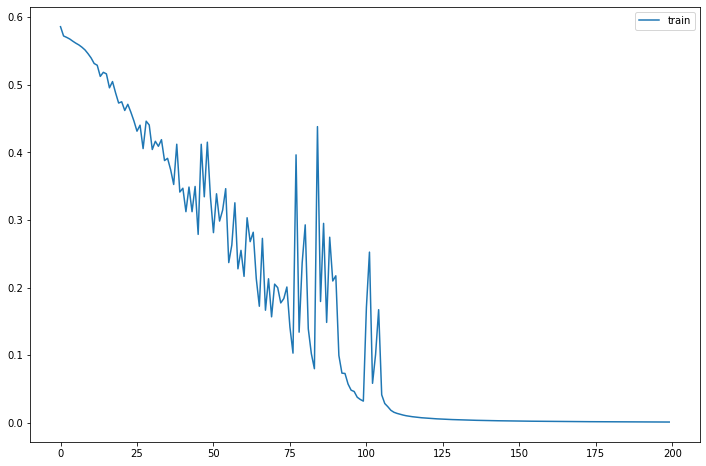

In [68]:
plt.figure(figsize=(12, 8))
plt.plot(model.train_costs, label='train')
plt.legend()

In [70]:
print("Final Loss on train data:", model.train_costs[-1])

Final Loss on train data: 0.0011997521460378586


In [74]:
confusion_matrix = np.zeros((2, 2))
for i in range(len(y_pred)):
    confusion_matrix[y_test[i][0]][y_pred[i][0]] += 1
acc = np.diag(confusion_matrix).sum() / np.sum(confusion_matrix)
recall = confusion_matrix[1][1] / confusion_matrix.sum(axis=1)[1]
precision = confusion_matrix[1][1] / confusion_matrix.sum(axis=0)[1]
print('Accuracy:', acc)
print('Recall:', recall)
print('Precision:', precision)

Accuracy: 0.8
Recall: 0.8181818181818182
Precision: 0.8709677419354839


In [107]:
EPOCHS = np.random.randint(1, 200, size=5)
ALPHAS = np.random.uniform(0.001, 0.2, size=5)

In [108]:
nn_layout = [
(64*64*3, 500, relu),
(500, 100, relu),
(100, 20, relu),
(20, 1, sigmoid),
        ]
for i in range(5):
    model = NeuralNetwork(nn_layout, ALPHAS[i])
    model.fit(X_train/255, y_train, epochs=EPOCHS[i])
    y_pred = model.predict(X_test/255).astype(int)
    print("Learning rate:", ALPHAS[i])
    print("epochs:", EPOCHS[i])
    print("Acc:", (y_pred == y_test).mean())

Learning rate: 0.014179019884682367
epochs: 44
Acc: 0.78
Learning rate: 0.026673375547765724
epochs: 118
Acc: 0.78
Learning rate: 0.028478501165568906
epochs: 198
Acc: 0.82
Learning rate: 0.18404557135368696
epochs: 127
Acc: 0.44
Learning rate: 0.07035940387621856
epochs: 63
Acc: 0.78


در گریدسرچ مقدار‌های کاندید هر پارامتر تعیین شده و سپس تمام ترکیب‌های آنها امتحان می‌شود و بهترین ترکیب انتخاب می‌شود.

از سوی دیگر در روش رندوم سرچ به صورت تصادفی مقدارهایی برای هر پارامتر انتخاب می‌شوند و این پارامتر‌ها مانند کد بالا امتحان می‌شوند.

در روش گرید سرچ چون که نیاز است تمام ترکیب‌ها امتحان شوند به شدت زمان زیادی برای اجرا نیاز است و همچنین به علت ثابت بودن نقاط انتخابی ممکان است اصلا نقاط اپتیمم در نقاط انتخابی نباشند.

هر چند که ممکن است روش رندوم به جواب بهینه‌ی گریدسرچ نرسد اما معمولا این روش بسیار بهتر از گریدسرچ عمل میکند و به علت تصادفی بودن فرآیند نقاط مختلفی از فضا انتخاب میشوند.


همانطور که در تصویر میبنید در روش گریدسرچ ممکن است که ناحیه اپتیمم به کلی نادیده گرفته شود.

<img src="https://miro.medium.com/max/700/1*9W1MrRkHi0YFmBoHi9Y2Ow.png">

وزن‌های رندوم این شانس را میدهند که تقارن در مدل شکسته شود زیرا اگر وزن‌ها یکسان باشند هر نورون دقیقا وزودی‌های یکسان با وزن‌های یکسان خواهد داشت و عملا فرقی بین نورون‌ها نخواهد بود و یادگیری صورت نمیگیرد.

مطلوب این است که به صورت تصادفی قسمت‌های مختلف مدل شروع به یادگیری داده‌ها به صورت های مختلف کنند.

از سوی دیگر روشهای ایتریتیو مانند گریدینت دیسنت با مقادیر ثابت عملکرد خوبی ندارند و بهترین کار شروع تصادفی از نقاط مختلف فضای وزن‌هاست .
همچنین در صورتی که بخواهیم مدل‌را که در مینیموم محلی اس دوباره آموزش بدیم به وزن‌های جدیدی نیاز است تا در مینیموم محلی قبلی دوباره گیر نکنیم.

:اکتیویشن فانکشن‌های متعارف

Step:
<img src="https://miro.medium.com/max/291/0*8U8_aa9hMsGmzMY2.">
به علت صفر و یکی بودن این تابع در کاربرد‌هایی که نیاز است چندین خروجی داشته باشیم مثلا دسته‌بندی چنددسته‌ای، ممکن است مقدار خزوجی برای چندین دسته یک شود، در این صورت تصمیم‌گیری سخت می‌شود.

از سوی دیگر صفر بودن مشتق آن در همه‌ی نقاط بجز صفر و نامحدود بودن مشتق آن در صفر استفاده از آن‌را کمی دشوار میکند.

Sigmoid:
<img src="https://miro.medium.com/max/485/1*Xu7B5y9gp0iL5ooBj7LtWw.png">
خروجی بین صفر و یک این تابع در کاربرهای مختلف بسیار مفید است و در پیشبینی احتمال به عنوان خروجی به خوبی عمل میکند.
از سوی دیگر تابع مشتق‌پذیر است و در روش‌های مبتنی بر گرادیان بسیار مفید است.
به علت اینکه مشتق آن فقط در ناحیه‌ی محدودی مقدار قابل‌ توجه دارد و در مابقی نقاط نزدیک صفر است در صورت عدم انتخاب درست وزن‌های اولیه و یا حتی در میانه‌ی یادگیری ممکن است این تابع مدل را در نقاط لوکال اپتیما متوقف کند.

Softmax function:

این روش، حالت کلی‌تر تابع لجستیک است که در طبقه‌بندی چندکلاسه بسیار مفید است.

Tanh:
<img width=400px src="https://ml-cheatsheet.readthedocs.io/en/latest/_images/tanh.png">

این تابع هم مانند سیگموید یک تابع غیرخطی است با این تفاوت که خروجی آن تابعی فرد بوده و به اصطلاح

zero-centered

است و همچنان مانند سیگموید دچار مشکل

vanishing gradients

است.

Relu and Leaky-Relu:

<img src="https://miro.medium.com/max/700/1*A_Bzn0CjUgOXtPCJKnKLqA.jpeg">
این تابع خیرخطی بوده و از نظر محاسباتی بسیار ساده است.
از طرف دیگر همان مزایای سیگموید را دارد ولی از 

vanishing gradients 

رنج نمیبرد.

به علت برد صفر تا بینهایت آن فقط باید در لایه‌های داخلی شبکه‌های عصبی مورد استفاده بگیرد.

به علت صفر بودن آن در مقدار‌های منفی ممکن است بعضی از نورون‌ها هیچگاه شانس فعال شدن و آپدیت مقدار خود را نداشته باشند و از این رو نورون بمیرد.

مشکل بالا در روش لیکی رلو حل شده است به این صورت که در مقدارهای منفی یک خط با شیب بسیار کم است.


## Part Three

در این روش تنها کافی است مدل مربوطه را کتابخانه‌اش ایمپورت کنیم.

In [177]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifier

In [207]:
model = SVC(kernel='poly', degree=3, probability=True)
model.fit(X_train.reshape((X_train.shape[0], -1))/255, y_train)
y_pred = model.predict(X_test.reshape((X_test.shape[0], -1))/255).reshape((-1,1))
confusion_matrix = np.zeros((2, 2))
for i in range(len(y_pred)):
    confusion_matrix[y_test[i][0]][y_pred[i][0]] += 1
acc = np.diag(confusion_matrix).sum() / np.sum(confusion_matrix)
recall = confusion_matrix[1][1] / confusion_matrix.sum(axis=1)[1]
precision = confusion_matrix[1][1] / confusion_matrix.sum(axis=0)[1]
print('Accuracy:', acc)
print('Recall:', recall)
print('Precision:', precision)

/home/hezardastan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.82
Recall: 0.7878787878787878
Precision: 0.9285714285714286


In [229]:
y_prob = model.predict_proba(X_train.reshape((X_train.shape[0], -1))/255)
print("Cost of Train data:", cost_func(y_prob[:, 1], y_train.flatten()))


Cost of Train data: 0.7614025422190001


اس وی ام‌ها از زمان ظهور خود به شدت عملکرد‌های خوبی داشته اند.
با استفاده از کرنل‌های پولینومیال در این مدل میتوان از ارتباط بین پیکسل‌های مختلف استفاده کرد چون که در تصاویی پیکسل‌های مختلف از هم مستقل نبوده و مخصوصا پیکسل‌هایی که از نظر فضایی به هم نزدیک باشند به هم وابستگی دارند.
اس وی ام در یادگیری داده‌های خطی و غیر خطی بسیار قوی بوده و چون داده‌هارا به صورت غیر مستقیم به فضای جدید میبرد بسیار سریع است.

پارامترهای آن کرنل، درجه‌ی تبدیل چندجمله‌ای، گاما و ... است که فقط دوتای اول را تیون میکنیم.
کرنل تابع مورد استفاده برای بردن داده‌ها به فضای جدید است.
در صورت انتخاب کرنل چند جمله‌ای،‌درجه‌ی آن را نیز میتوان انتخاب کرد

 <table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Acc</th>
    <th>Recall</th>
    <th>Precision</th>
    <th>Train Loss</th>  
  </tr>
  <tr>
    <th>Logistic Regression</th>
    <th>0.66</th>
    <th>0.60</th>
    <th>0.83</th>
    <th>0.3120</th>  
  </tr>
  <tr>
    <th>Neural Net</th>
    <th>0.80</th>
    <th>0.81</th>
    <th>0.87</th>
    <th>0.001199</th>
  </tr>
  <tr>
    <th>SVC</th>
    <th>0.82</th>
    <th>0.78</th>
    <th>0.92</th>
    <th>0.558</th>
  </tr>
</table> 


در روش اول عملکرد مدل بسیار ساده بود و تمام پیکسل‌ها از هم مستقل در نظر گرفته میشدند و هر کدام وزن خاص خود را داشتند و یک ضرب برداری و یک جمع ساده مارا به جواب میرساند و به شدت مدل سریع بود.


در روش دوم پیکسل‌های مختلف برای تولید فیچر‌های جدید با هم ترکیب میشدند و در هر لایه فیچرهای پیچیده‌تری ساخته میشدند که در نهایت باعث افزایش دقت نیز شد. ولی از نظر زمانی بسیار سنگین بود.


در روش سوم بهترین هر دو دنیا را داشتیم و با استفاده از کرنل تریک اس وی ام به سرعت داده‌هارا به صورت غیر صریح به فضای جدید چندجمله ای بردیم و با ترکیب پیکسل‌های مختلف فیچر‌های جدیدی برای یادگیری ساختیم و به همین علت دقت این مدل کمی بهتر از نورال اولیه و در حد بهترین مدل انتخاب شده در رندوم سرچ بود.
